In [240]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [241]:
def plot_sys(v,t):
        plt.plot(t,v(t))
        plt.xlabel('Quantity of water consumed')
        plt.ylabel('Average rate of flow')

In [242]:
k_0 = 700#Carrying capacity 
x_0 =300
def logistic(q, k=k_0,r= 0.005):
    return k_0/(1+ np.exp(-r*(q-x_0)))

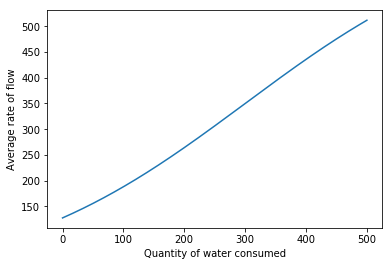

In [243]:
x = np.linspace(1,6, 10)
q= np.linspace(0,500,10000)
plot_sys(logistic,q)
plt.show()

In [244]:
s_0 = 370
# Requires: v0: initial volume
#           T:  timesteps
#           T_drink: times of drinking
#           Q: The corresponding amount drunk
#           s0: the constant of threshold for firing
#           k, r: the parameters of logistic
#           PROP: proportion of the water drunk that reaches bladder (const. set to 0.68)
# Modifies: nothing
# Returns: V, the volume of liquid in bladder
#          R, the rates
def integ_fire(T, T_drink, Q, model_type = 1,
               v0=0, s0=s_0, k=k_0, r=0.01, PROP=0.68):
    
        q = np.linspace(0,1000,10000)
        MINr = min(logistic(q,k,r)) 
        epsilon_r = 0
        thresh = s0 # modify if needed
        V = np.zeros(len(T)) # volume of bladder
        R = np.zeros(len(T)) # keeping R
        
        rbar = 0#float(logistic(np.mean(q), k, r)) /60 # a default value
        t_total = T[-1]#PROP*np.mean(q)/rbar # a default value 
        q = 0
        
        i_drink = 0
        t_prevDrink = 0
        number_of_firings =0
        alpha = 37/4500
        
        for i, t in enumerate(T[:-1]):
                
            if (t in T_drink):
              
                if (t-t_prevDrink > t_total):
                    q = Q[i_drink]
                else:
                    #print('early drink')
                    q = (1/PROP)*rbar*(t_total - (t - t_prevDrink)) + Q[i_drink]
                    
                
                rbar = logistic(q, k, r)/60 # from ml/hr to ml/min
                #print(rbar,q,int(t_total),t,int(t_prevDrink))
                t_total = PROP*q/rbar
                i_drink += 1
                t_prevDrink = t
            if model_type == 1:
                if t - t_prevDrink <=t_total:
                    rate = rbar # this is for const rate
                else:
                    rate =0
                V[i+1] = V[i] + rate
                R[i] = rate
            elif model_type == 2:
                rate = max(2*rbar*(1 - (t-t_prevDrink)/t_total), 0) # this is dV/dt # this is for variable r
                V[i+1] = V[i] + rate
                R[i] = rate
            indices = np.where(np.logical_and(T_drink>=t_prevDrink, T_drink<=t))
            thresh = s_0 - 0.68*alpha*sum((t-T_drink[indices])*Q[indices])
            if (V[i] > thresh):
                #print('Fire')
                V[i+1] = 0
                if V[i] !=0:
                    number_of_firings +=1
                #print(number_of_firings)
            

            
        return V, R,number_of_firings
                    

In [245]:
T = [x for x in range(24*60)] # over a day

T_drink = set()
Q = []
for i in range(20):
    #chooses 20 random times to drink in the day
    T_drink.add(random.choice(T))
    Q = Q + [random.randint(0, 500)]
    

In [246]:
np.array(T_drink)

array(set([691, 32, 1316, 965, 1031, 1161, 810, 225, 110, 1327, 1360, 273, 690, 561, 692, 213, 599, 516, 602, 517]), dtype=object)

In [247]:
sum(np.array(Q))

4629

In [248]:
intfi = integ_fire(T, T_drink, Q, 1)
plt.plot(T, intfi[0])
plt.show()

TypeError: 'set' object has no attribute '__getitem__'

In [249]:
intfi = integ_fire(T, T_drink, Q, 2)
plt.plot(T, intfi[0])
plt.show()

TypeError: 'set' object has no attribute '__getitem__'

### The k for most people

Most people go to the bathroom 7 times a day. They sleep around 8 hours a day. Let us think that the frequency of going to the bathroom is 7/16 times per hour.


In [250]:
T_usual = np.array(range(8*60)) # times at a 9-5 job
q_usual = 250*np.ones(6)
T_drink_usual = np.array(range(90,8*60,180))

In [251]:
T_drink_usual

array([ 90, 270, 450])

1


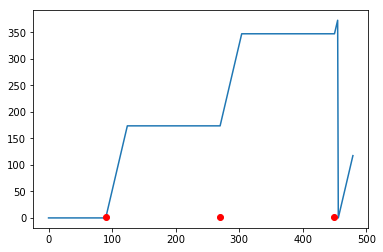

In [252]:
intfi = integ_fire(T_usual, T_drink_usual, q_usual, 1,r=0.005,k=350)
plt.plot(T_usual, intfi[0])
plt.plot(T_drink_usual,np.ones(len(T_drink_usual)),'ro')#drinking times
print(intfi[2])
plt.show()

In [253]:
div = 100
rrange =[0.001,0.001,0.005,0.01,0.05,0.1,0.5,1,1.5,2,10]
krange = np.linspace(350,700,50)
for r in rrange:
    for k in krange:
        n  = integ_fire(T_usual, T_drink_usual, q_usual, 2,r=0.005,k=350)[2]
        if n >=3 :
            print(r,k)

In [254]:
n

1

In [255]:
r

10

### Coupling

In [256]:
s_0 = 370
# Requires: 
#           v0: initial volume
#           T:  timesteps
#           T_drink: times of drinking
#           Q: The corresponding amount drunk
#           s0: the constant of threshold for firing
#           k, r: the parameters of logistic
#           PROP: proportion of the water drunk that reaches bladder (const. set to 0.68)
#           n: number of oscillators involved this has to be 2 for now!
#           delta: the time one spends in/on the way to bathroom (in minutes)
# Modifies: nothing
# Returns: V, the volume of liquid in bladder
#          R, the rates
def coupled_integ_fire(T, T_drink, Q, model_type = 1,
               v0=0, s0 = s_0, k=k_0, r=0.01, PROP=0.68, 
                       n = 2, delta = 5):
        
        q = np.linspace(0,1000,10000)
        MINr = min(logistic(q,k,r)) 
        epsilon_r = 0
        thresh = np.ndarray(n) # modify if needed
        thresh[0] = s_0
        thresh[n-1] = s_0 + 40
        V = [np.zeros(len(T)) for x in range(n)] # volume in bladders
        R = [np.zeros(len(T)) for x in range(n)]  # keeping Rs
        
        rbar = [0 for x in range(n)]#float(logistic(np.mean(q), k, r)) /60 # a default value
        t_total = [T[-1] for x in range(n)]#PROP*np.mean(q)/rbar # a default value 
        q = np.ndarray(n)
        q[:] = 0
        
        i_drink = [0, 0]
        t_prevDrink = np.ndarray(n)
        t_prevDrink[:] = 0
        
        fired = False
        refractory_effect = [False, False]
        T_fire = [10000, 20000]
        for i, t in enumerate(T[:-1]):
            # if they see each other in the bathroom, they try to go later
            # next time
            if (fired and
                abs(T_fire[1] - T_fire[0]) < delta):
                thresh += 0.1*thresh # 10% increase in thresh
                fired = False
                T_fire = [10000, 20000]
                refractory_effect = [True, True]
                
            for osc in range(n):
                if (t in T_drink[osc]):
                    if (t-t_prevDrink[osc] > t_total[osc]):
                        q[osc] = Q[osc][i_drink[osc]]
                    else:
                        #print('early drink')
                        q[osc] = (1/PROP)*rbar[osc]*(t_total[osc] 
                                                     - (t - t_prevDrink[osc])) + Q[osc][i_drink[osc]]

                    rbar[osc] = logistic(q[osc], k, r)/60 # from ml/hr to ml/min
                    #print(rbar)
                    t_total[osc] = PROP*q[osc]/rbar[osc]
                    i_drink[osc] += 1
                    t_prevDrink[osc] = t
                if (V[osc][i] > thresh[osc]):
                    #print('Fire')
                    V[osc][i+1] = 0
                    T_fire[osc] = t
                    fired = True
                    if (refractory_effect[osc]):
                        thresh[osc] = s_0 + osc*40
                        refractory_effect[osc] = False
                    continue
                if model_type == 1:
                    if (t-t_prevDrink[osc] > t_total[osc]):
                        rate = 0
                    else:
                        rate = rbar[osc] # this is for const rate
                    V[osc][i+1] = V[osc][i] + rate
                    R[osc][i] = rate
                elif model_type == 2:
                    rate = max(2*rbar[osc]*(1 - 
                                            (t-t_prevDrink[osc])/t_total[osc]), 0) # this is dV/dt # this is for variable r
                    V[osc][i+1] = V[osc][i] + rate
                    R[osc][i] = rate



        return V, R

In [257]:
# test for 2 peers
T = [x for x in range(24*60)] # over a day


n = 2 # number of oscillators
T_drink = [set() for x in range(n)]
Q = [[] for x in range(n)]
for osc in range(n):
    for i in range(20):
        #chooses 20 random times to drink in the day
        T_drink[osc].add(random.choice(T))
        Q[osc] = Q[osc] + [random.randint(0, 500)]
        
    
T_usual = np.array(range(9*60)) # times at a 9-5 job
q_usual = [250*np.ones(6) for x in range(2)]
T_drink_usual = [np.array(range(90,20*60,180)) for x in range(2)]

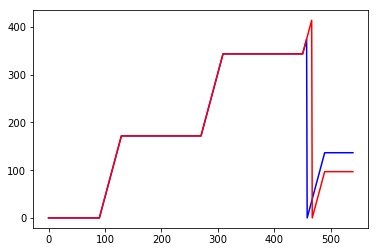

In [258]:
intfi_couple = coupled_integ_fire(T_usual, T_drink_usual, q_usual, 1, n=n, delta = 10)
plt.plot(T_usual, intfi_couple[0][0], 'b')
plt.plot(T_usual, intfi_couple[0][1], 'r')
plt.show()

In [259]:
T_drink_usual

[array([  90,  270,  450,  630,  810,  990, 1170]),
 array([  90,  270,  450,  630,  810,  990, 1170])]